In [2]:
import pandas as pd

file_path = "../data/processed/merged_macro_data.csv"  
merged_data = pd.read_csv(file_path)

merged_data["Month_Num"] = pd.to_datetime(merged_data["Month"], format="%B").dt.month

merged_data["Year"] = merged_data["Year"].astype(int)

lag_features = ["CPI_Index", "PPI_Index", "Avg_Fed_Funds_Rate", "GDP_Value", 
                "Unemployment_Rate", "Money_Supply_M2", "Consumer_Sentiment_Index", "VIX_Index"]

for col in lag_features:
    for lag in [1, 3, 6, 12]:  
        merged_data[f"{col}_Lag_{lag}"] = merged_data[col].shift(lag)

for col in lag_features:
    for window in [3, 6, 12]:  
        merged_data[f"{col}_Roll_{window}"] = merged_data[col].rolling(window=window).mean()
        
merged_data["Inflation_Rate"] = merged_data["CPI_Index"].pct_change() * 100

merged_data["PPI_CPI_Ratio"] = merged_data["PPI_Index"] / merged_data["CPI_Index"]
merged_data["Fed_Unemp_Ratio"] = merged_data["Avg_Fed_Funds_Rate"] / merged_data["Unemployment_Rate"]
merged_data["Money_GDP_Ratio"] = merged_data["Money_Supply_M2"] / merged_data["GDP_Value"]

volatility_features = ["CPI_Index", "PPI_Index", "VIX_Index"]

for col in volatility_features:
    merged_data[f"{col}_Volatility"] = merged_data[col].rolling(window=6).std()

merged_data["Fed_Unemp_Interaction"] = merged_data["Avg_Fed_Funds_Rate"] * merged_data["Unemployment_Rate"]
merged_data["CPI_Money_Interaction"] = merged_data["CPI_Index"] * merged_data["Money_Supply_M2"]

merged_data["PPI_Lead_3"] = merged_data["PPI_Index"].shift(-3)
merged_data["Fed_Rate_Lead_6"] = merged_data["Avg_Fed_Funds_Rate"].shift(-6)

merged_data.fillna(method="ffill", inplace=True) 

merged_data.dropna(inplace=True)

processed_file_path = "../data/processed/feature_engineered_macro_data.csv"
merged_data.to_csv(processed_file_path, index=False)

/var/folders/ng/wr8jbtzd7vd34mpv1ddk7qvc0000gn/T/ipykernel_44806/1743416207.py:38: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_data.fillna(method="ffill", inplace=True)


🔹 **Top Features Most Positively Correlated with CPI Index:**
CPI_Index            1.000000
CPI_Index_Roll_3     0.999900
CPI_Index_Lag_1      0.999873
CPI_Index_Roll_6     0.999636
CPI_Index_Lag_3      0.999318
CPI_Index_Roll_12    0.999132
CPI_Index_Lag_6      0.998451
CPI_Index_Lag_12     0.996923
GDP_Value_Lag_12     0.994736
GDP_Value_Roll_12    0.994478
Name: CPI_Index, dtype: float64

🔹 **Top Features Most Negatively Correlated with CPI Index:**
Avg_Fed_Funds_Rate_Lag_1          -0.432416
Consumer_Sentiment_Index_Roll_3   -0.432615
Consumer_Sentiment_Index          -0.433069
Avg_Fed_Funds_Rate_Roll_3         -0.433473
Avg_Fed_Funds_Rate_Roll_6         -0.453252
Avg_Fed_Funds_Rate_Lag_3          -0.455106
Avg_Fed_Funds_Rate_Lag_6          -0.492340
Avg_Fed_Funds_Rate_Roll_12        -0.500323
Avg_Fed_Funds_Rate_Lag_12         -0.574636
Fed_Unemp_Interaction             -0.600119
Name: CPI_Index, dtype: float64


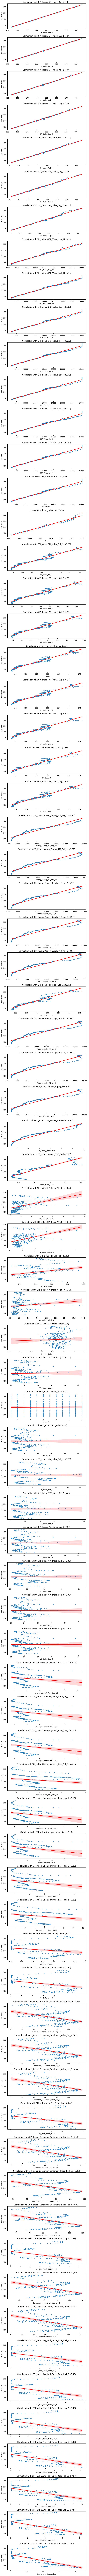

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

numeric_data = merged_data.select_dtypes(include=["number"])

cpi_correlation = numeric_data.corr()["CPI_Index"].sort_values(ascending=False)

print("Top Features Most Positively Correlated with CPI Index:**")
print(cpi_correlation.head(10))

print("Top Features Most Negatively Correlated with CPI Index:")
print(cpi_correlation.tail(10))

numeric_data = merged_data.select_dtypes(include=["number"])

cpi_correlation = numeric_data.corr()["CPI_Index"].sort_values(ascending=False)

num_features = len(cpi_correlation) - 1 
fig, axes = plt.subplots(nrows=num_features, figsize=(8, num_features * 3))

for i, (feature, correlation) in enumerate(cpi_correlation.items()):
    if feature != "CPI_Index":  
        ax = axes[i - 1]
        sns.regplot(x=numeric_data[feature], y=numeric_data["CPI_Index"], ax=ax, scatter_kws={"s": 10}, line_kws={"color": "red"})
        ax.set_title(f"Correlation with CPI_Index: {feature} ({correlation:.2f})", fontsize=12)
        ax.set_xlabel(feature, fontsize=10)
        ax.set_ylabel("CPI_Index", fontsize=10)
plt.tight_layout()
plt.show()